# Feature Normalization and Pairwise Transform

In this notebook, we cover the third step of Learning to Rank: Before training a model, LTR often requires a level of transformation to make the the problem suitable for classic machine learning approaches. In this notebook, we transform our the judgment list generated from [the previous step](2.judgments-and-logging.ipynb) first by normalizing the features using their mean & stand deviation. After that we examine a pair-wise transform used by the SVMRank model to make LTR a binary classification problem.

In [1]:
import numpy
from aips import *
import aips.indexer

engine = get_engine()
aips.indexer.download_data_files("judgments")
tmdb_collection = aips.indexer.build_collection(engine, "movies")

## Log large training set

Log the full training set of ~100 movie queries, each with ~40 graded documents. Save judgment list with features logged as `logged_judgments`

In [3]:
from ltr.log import FeatureLogger
from ltr.judgments import judgments_open
from itertools import groupby

collection = engine.get_collection("tmdb")
ftr_logger=FeatureLogger(index=collection, feature_set="movie_model")

with judgments_open("data/ai_pow_search_judgments.txt") as judgment_list:
    for qid, query_judgments in groupby(judgment_list, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))

logged_judgments = ftr_logger.logged

# Now should have lots of judgments with title_bm25, overview_bm25, and release_year 
# logged out
print("Sample of Logged Judgments:")
display(logged_judgments[0:10])

Duplicate docs in for query id 67: {'2503'}
Missing doc 225130 with error
Missing doc 37106 with error
Duplicate docs in for query id 74: {'11852'}
Missing doc 61919 with error
Missing doc 67479 with error
Missing doc 17882 with error
Duplicate docs in for query id 95: {'17431'}
Duplicate docs in for query id 98: {'1830'}
Parsing QID 100
Duplicate docs in for query id 99: {'9799'}
Missing doc 61920 with error
Sample of Logged Judgments:


[Judgment(grade=1,qid=1,keywords=rambo,doc_id=7555,features=[5.9264307, 5.078817, 2008.0],weight=1),
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1370,features=[5.025649, 5.751174, 1988.0],weight=1),
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1369,features=[3.4517245, 4.8904457, 1985.0],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=13258,features=[0.0, 4.5890946, 2007.0],weight=1),
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1368,features=[0.0, 5.394124, 1982.0],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=31362,features=[0.0, 3.7886639, 1988.0],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=61410,features=[0.0, 2.1226306, 2010.0],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=319074,features=[0.0, 0.0, 2015.0],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=10296,features=[0.0, 0.0, 2004.0],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=35868,features=[0.0, 0.0, 2001.0],weight=1)]

## Plot logged features

*Source for Figs 10.7*

This data set also has queries `star wars` and `social network` let's see what those look like by plotting the raw BM25 features we logged for documents labeled relevant / irrelevant.

Data points note:

- The green + in the upper right is "The Social Network"
- The red + with the largest `title_bm25` score is "Star Wars"
- The red + with ~6 `title_bm25` and ~5 `overview_bm25` is "Star Wars: The Clone Wars"

/home/jovyan/ltr/plots.py:49: UserWarning:

No data for colormapping provided via 'c'. Parameters 'norm' will be ignored



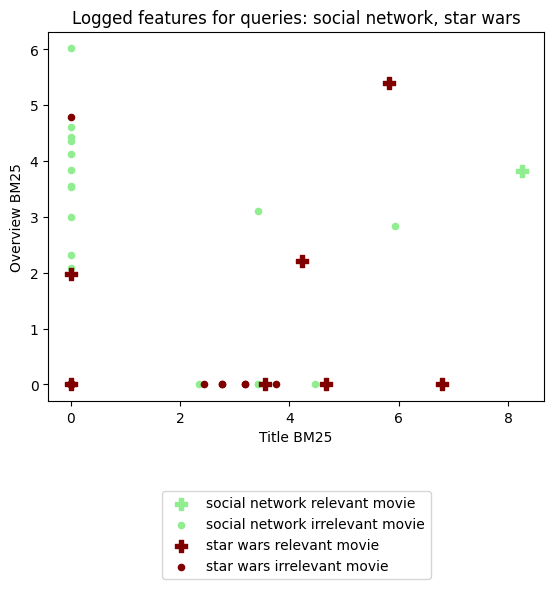

In [4]:
from ltr.plots import plot_judgments

plot_judgments(qids=[11,40], focus=[11,40], 
               xlabel="Title BM25",
               ylabel="Overview BM25",
               title_prepend="Logged features for queries:",
               judg_list=ftr_logger.logged)

## Feature Normalization Function (omitted from book)

As we describe in the book, SVMs are sensitive to the range of the underlying data. They work best with normalized features, which we do here.

This function computes the mean and standard deviation of all 3 of our features, then scales each feature value accordingly so that feature values at the mean are mapped to 0. And +1 corresponds to 1 std deviation above the mean. -1 1 standard deviation below, etc

We capture the mean and standard deviation of each feature for later work

In [5]:
from ltr.judgments import Judgment

def normalize_features(logged_judgments):
    all_features = []
    means = [0,0,0]
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            means[idx] += f
        all_features.append(judgment.features)
    
    for i in range(len(means)):
        means[i] /= len(logged_judgments)
      
    std_devs = [0.0, 0.0, 0.0]
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            std_devs[idx] += (f - means[idx])**2
            
    from math import sqrt
    for i in range(len(std_devs)):
        std_devs[i] /= len(logged_judgments)
        std_devs[i] = sqrt(std_devs[i])
        
    # Normalize!
    normed_judgments = []
    for judgment in logged_judgments:
        normed_features = [0.0] * len(judgment.features)
        for idx, f in enumerate(judgment.features):
            normed = (f - means[idx]) / std_devs[idx]
            normed_features[idx] = normed
        normed_judgment=Judgment(qid=judgment.qid,
                                 keywords=judgment.keywords,
                                 doc_id=judgment.doc_id,
                                 grade=judgment.grade,
                                 features=normed_features)
        normed_judgment.old_features=judgment.features
        normed_judgments.append(normed_judgment)

    return means, std_devs, normed_judgments

means, std_devs, normed_judgments = normalize_features(ftr_logger.logged)

print("Sample of Normed Judgments:")
normed_judgments[0:10]

Sample of Normed Judgments:


[Judgment(grade=1,qid=1,keywords=rambo,doc_id=7555,features=[3.101419298310874, 2.9435572663457967, 0.7345398019737361],weight=1),
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1370,features=[2.5643638127604715, 3.39208088257628, -0.2672174491148639],weight=1),
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1369,features=[1.6259735384385419, 2.817896379837532, -0.4174810367781539],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=13258,features=[-0.4319807665098383, 2.6168676330154805, 0.6844519394193062],weight=1),
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1368,features=[-0.4319807665098383, 3.1538958749462647, -0.5677446244414439],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=31362,features=[-0.4319807665098383, 2.082907144605458, -0.2672174491148639],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=61410,features=[-0.4319807665098383, 0.9715105495281311, 0.8347155270825962],weight=1),
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=319074,features=[-0.4319

## Listing 10.8 - Normalize

Perform the normalization, and inspect the difference between of "The Social Network" between raw/logged and normalized feature values. 

In [6]:
means, std_devs, normed_judgments = normalize_features(logged_judgments)
display(logged_judgments[360])
display(normed_judgments[360])

Judgment(grade=1,qid=11,keywords=social network,doc_id=37799,features=[8.243603, 3.8143613, 2010.0],weight=1)

Judgment(grade=1,qid=11,keywords=social network,doc_id=37799,features=[4.482941696779275, 2.100049660821875, 0.8347155270825962],weight=1)

## Examine normalized judgments
*Source for Figs 10.8-10.11*

Examine the normalized judgments now, in preperation for transforming them with SVMRank's pair-wise transform

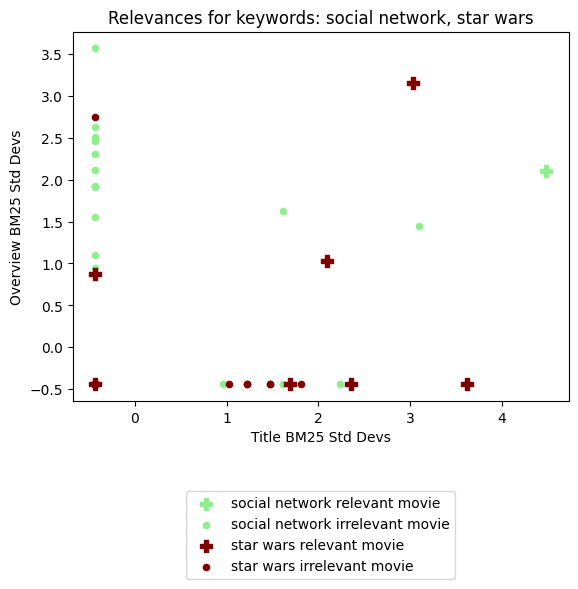

In [7]:
from ltr.plots import plot_judgments

plot_judgments(qids=[11,40], 
               xlabel="Title BM25 Std Devs",
               ylabel="Overview BM25 Std Devs",
               title_prepend="Relevances for keywords:",
               judg_list=normed_judgments)

# Listing 10.9 (Python Equivalent)

Pairwise transformation from per-query judgmens -> feature and predictor deltas

We put psuedocode in the book, but here we show the equivelant Python code. This code also transforms the data to a numpy array of predictors and features for later model training with an SVM.

In [8]:
def pairwise_transform(normed_judgments):
        
    from itertools import groupby
    predictor_deltas = []
    feature_deltas = []
    
    # For each query's judgments
    for qid, query_judgments in groupby(normed_judgments, key=lambda j: j.qid):
        query_judgments = list(query_judgments)

        # Examine every judgment combo for this query, 
        # if they're different, store the pairwise difference:
        # +1 if doc1_judgment more relevant
        # -1 if doc2_judgment more relevant
        for doc1_judgment in query_judgments:
            for doc2_judgment in query_judgments:
                j1_features = numpy.array(doc1_judgment.features)
                j2_features = numpy.array(doc2_judgment.features)
                             
                if doc1_judgment.grade > doc2_judgment.grade:
                    predictor_deltas.append(1)
                    feature_deltas.append(j1_features -
                                          j2_features)
                elif doc1_judgment.grade < doc2_judgment.grade:
                    predictor_deltas.append(-1)
                    feature_deltas.append(j1_features -
                                          j2_features)

    # For training purposes, we return these as numpy arrays
    return numpy.array(feature_deltas), numpy.array(predictor_deltas)

feature_deltas, predictor_deltas = pairwise_transform(normed_judgments)

## Pair-wise deltas, Star Wars and Social Network
*source for Fig 10.9*

The training set showing pair-wise differences in each feature for each relevant / irrelevant combo in each query

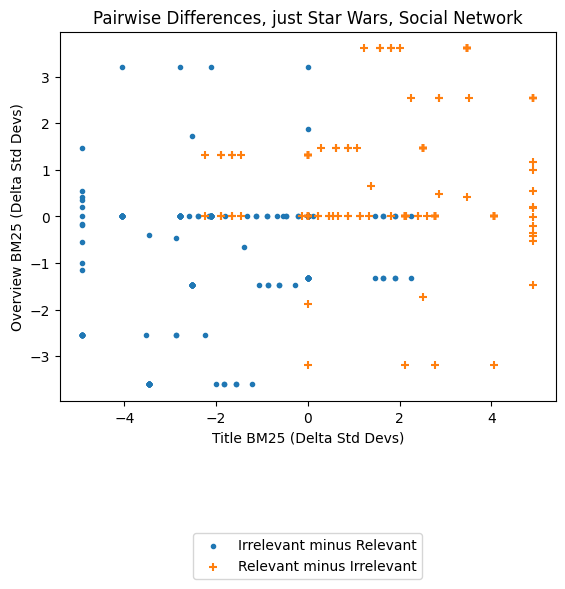

In [9]:
from ltr.plots import plot_pairwise_data

# Filter down to a judgment list of our two fav queries 
# out of the normalized data
just_star_wars_social_network = []
for j in normed_judgments:
    if j.qid == 11 or j.qid == 40:
        just_star_wars_social_network.append(j)

# Pairwise transform just these two, and plot
features, predictors = pairwise_transform(just_star_wars_social_network)
plot_pairwise_data(features, predictors,
                   xlabel="Title BM25 (Delta Std Devs)",
                   ylabel="Overview BM25 (Delta Std Devs)",
                   title="Pairwise Differences, just Star Wars, Social Network")

## Full dataset pairwise differences

*Source for Figure 10.14*

Note now with the full dataset's pairwise deltas computed, we can see relevant examples have a higher, positive `title_bm25` as we might expect.

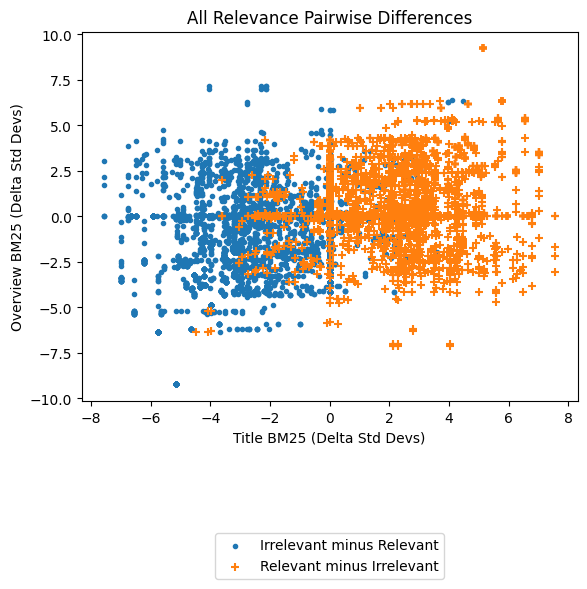

In [10]:
from ltr.plots import plot_pairwise_data

plot_pairwise_data(feature_deltas, predictor_deltas,
                   xlabel="Title BM25 (Delta Std Devs)",
                   ylabel="Overview BM25 (Delta Std Devs)",
                   title="All Relevance Pairwise Differences")

## Save intermediate data

For the next notebook, we save off out normalized, transformed pair-wise data. We also save the normalized full judgment list so we can do a test-training split and evaluate the model.

In [11]:
from ltr.judgments import judgments_to_file

with open("data/feature_data.npy", "wb") as f:
    num_features=3
    feature_data = numpy.append(feature_deltas, [means, std_devs] )
    rows=feature_data.shape[0]//num_features    
    cols=num_features
    feature_data = feature_data.reshape((rows, cols))
    
    numpy.save(f, feature_data)
    
with open("data/predictor_deltas.npy", "wb") as f:
    numpy.save(f, predictor_deltas )
    
with open("data/normed_judgments.txt", "wt") as f:
    judgments_to_file(f, normed_judgments)

## Next up, finally training (and evaluating) a model

You're finally ready to train a model. Let's jump to it in the next and final notebook for the chapter.

Up next: [Train a Model, Evaluate, and Use in the Search Engine](4.train-and-evaluate-the-model.ipynb)